## Scanpy: trajectory analysis (PAGA)
元URL: https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

（更新日:2021-4-28）

Scanpyを用いた軌道解析です。軌道解析法には partition-based graph abstraction (PAGA; Wolf et al, 2019) を採用しています。PAGAは細胞数が多く軌道が複雑であるようなサンプルに対して有効であるとされています。

### 前準備
Google Colabで本チュートリアルを実行する場合は まず下記コマンドでScanpyをインストールしてください。

In [1]:
# scanpyインストール
!pip install seaborn scikit-learn statsmodels numba python-igraph louvain leidenalg scanpy # pytables 

In [18]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

# ログなどのパラメータ設定
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, frameon=False)  # low dpi (dots per inch) yields small inline figures
results_file = './write/paul15.h5ad' # 出力ファイル名

### データ読み込み
ここではscanpyライブラリ内で提供されている [paul15 データ](http://doi.org/10.1016/j.cell.2015.11.013)  (Hematopoiesis from self-renewing stem cells)を用います。
細胞アノテーションつきの 2,730 細胞データです。
Scanpyの中に同梱されており、以下のコマンドでロードできます。

In [33]:
adata = sc.datasets.paul15()
adata

# 異なる計算プラットフォームでも同じ結果が得られるように、デフォルトの「float32」よりも高い精度で作業します。
adata.X = adata.X.astype('float64') 

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


### 正規化、次元削減、クラスタリング

ここでは事前に用意されている[Zheng17](https://scanpy.readthedocs.io/en/latest/api/scanpy.pp.recipe_zheng17.html)のパラメータ設定を利用します。

In [34]:
# パラメータのロード（フィルタリング、HGVの抽出などが含まれます）
sc.pp.recipe_zheng17(adata)
# PCAの計算
sc.tl.pca(adata, svd_solver='arpack')

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)


In [35]:
# 第20主成分までを用いてグラフクラスタリング
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:17)


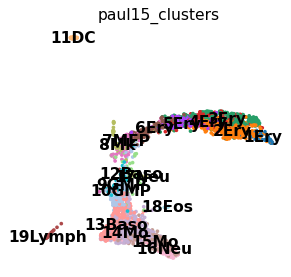

In [36]:
# 可視化
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

ここでは図はまだ乱雑なままです。

### Optional: Denoising the graph

ノイズ除去のために，グラフをdiffusion mapで表現することもできます。
いくつかのdiffusion成分内の距離を計算することはグラフをノイズ除去することと同じです。
これは、PCAを使ってデータマトリックスをノイズ除去することに非常に似ています。


In [37]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989278  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.98398703 0.983007   0.9790806  0.9762548
     0.9744365  0.9729161  0.9652972 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:16)


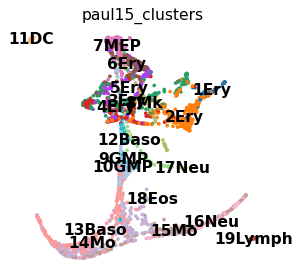

In [38]:
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

結果はまだ雑然としています。上図と異なり、多くのブランチがオーバープロットされています。

### PAGAの実行
PAGAは得られたクラスタを一つのノードとみなし、ノードごとの関係性を可視化することにより、大規模かつ複雑なグラフの「粗視化」ネットワークを推定します。

（現在はlouvainの代わりにleidenを使うことがおすすめです。）

粗視化されたグラフを可視化するためにPAGAグラフを利用します。
粗視化グラフの中では、重要でないエッジは除去されます。

In [39]:
# クラスタリング
sc.tl.louvain(adata, resolution=1.0)

# PAGA実行
sc.tl.paga(adata, groups='louvain')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


### クラスタのアノテーション
以下の既知のマーカを元に各クラスタをアノテートします。

|cell type|	marker|
|---|---|
|HSCs|	Procr|
|Erythroids|	Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1|
|Neutrophils|	Elane, Cebpe, Ctsg, Mpo, Gfi1|
|Monocytes|	Irf8, Csf1r, Ctsg, Mpo|
|Megakaryocytes|	Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf|
|Basophils|	Mcpt8, Prss34|
|B cells|	Cd19, Vpreb2, Cd79a|
|Mast cells|	Cma1, Gzmb, CD117/C-Kit|
|Mast cells & Basophils	|Ms4a2, Fcer1a, Cpa3, CD203c (human)|

--> added 'pos', the PAGA positions (adata.uns['paga'])


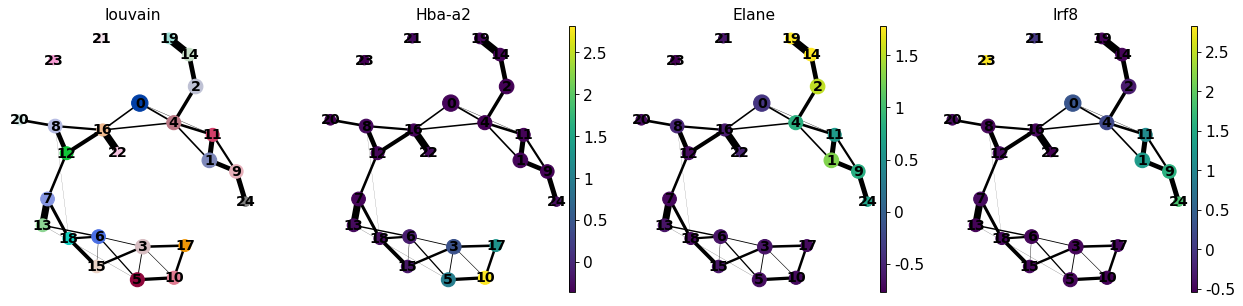

In [40]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


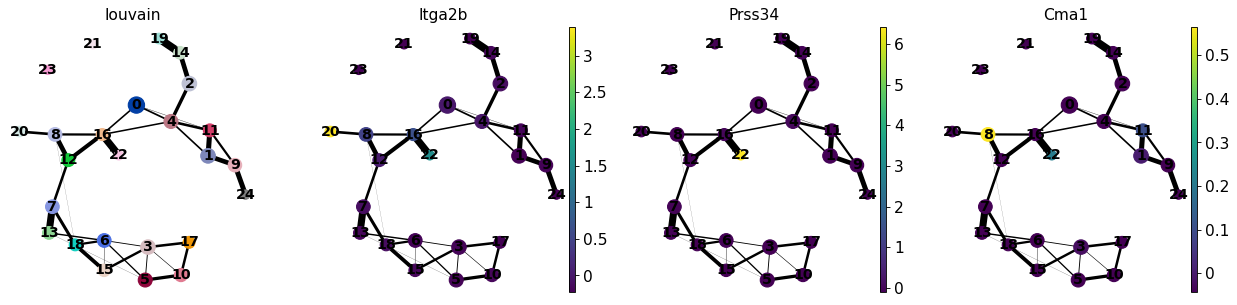

In [41]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

Cma1はMast細胞のマーカーであり、前駆細胞/幹細胞クラスター8のごく一部の細胞にしか現れないことに注意してください。

In [42]:
adata.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [43]:
# アノテーションをもとにクラスタのラベルを修正
adata.obs['louvain_anno'] = adata.obs['louvain']
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', 
                                            '8', '9', '10/Ery', '11', '12','13', '14', '15', 
                                            '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


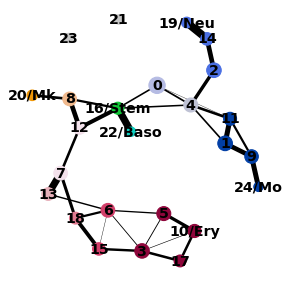

In [52]:
sc.tl.paga(adata, groups='louvain_anno')
sc.pl.paga(adata, threshold=0.03)

### 細胞レベルでの2次元プロット
PAGAで得られたクラスタレベルのネットワーク情報をもとに、細胞レベルでの2次元マップを再構築します。

In [45]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:16)


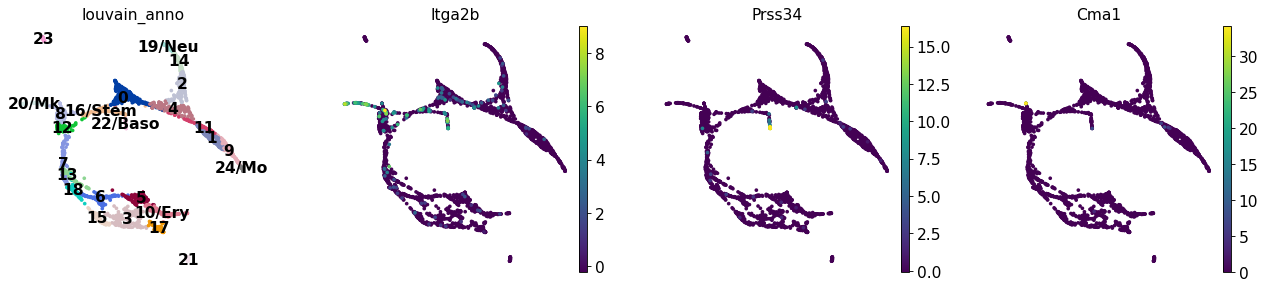

In [46]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

#### 色の変更
色が見づらいのでもう少し綺麗なカラーマップに変更します。

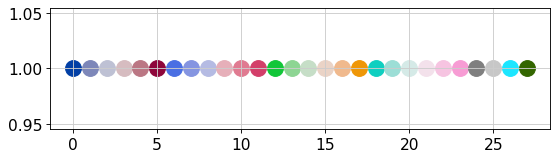

In [48]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [49]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['louvain_anno_colors'])

new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

adata.uns['louvain_anno_colors'] = new_colors

--> added 'pos', the PAGA positions (adata.uns['paga'])


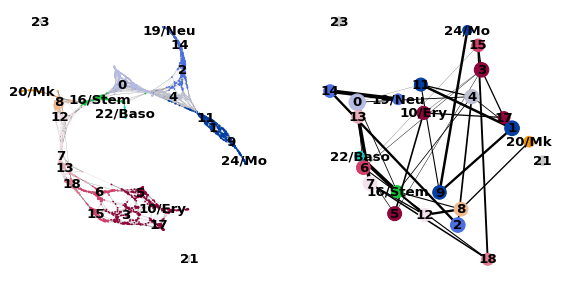

In [54]:
# 細胞レベルとクラスタレベルでの可視化
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

PAGAの軌道に沿った遺伝子発現の変化を可視化

In [56]:
# どのクラスタをrootにするかを選ぶ。ここでは16/Stemを選択
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [57]:
# 軌道解析のためのマーカ遺伝子を指定
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

In [58]:
# データを生成しなおし（adata.raw に格納）
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


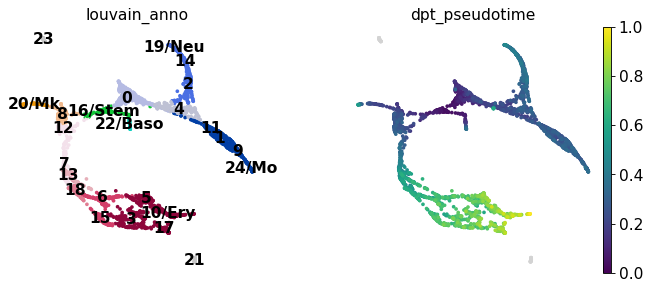

In [59]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [60]:
# パスの定義
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]

In [61]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']
adata.obs['clusters'] = adata.obs['louvain_anno']  # just a cosmetic change
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

In [62]:
!mkdir -p write

#### パスに沿った遺伝子の可視化

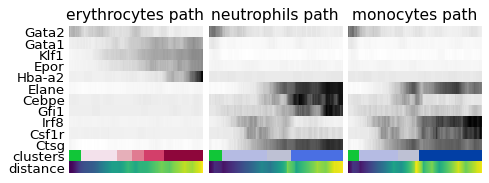

In [63]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()